In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Instructions for updating:
non-resource variables are not supported in the long term


# CNN(Convolutional Neural Network) - 합성곱 신경망  
MNIST 손글씨(숫자 0~9) 데이터 분류하기


In [2]:
# 불러오기
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()

# train data의 일부를 validation data로 만들기
(x_train, x_val) = (x_train[:50000], x_train[50000:])
(y_train, y_val) = (y_train[:50000], y_train[50000:])

# 형태 확인
print("x_train.shape :", x_train.shape)
print("x_val.shape   :", x_val.shape)
print("y_train.shape :", y_train.shape)
print("y_val.shape   :", y_val.shape)

# 손글씨 생김새 확인
for row in x_train[0]:
    for data in row:
        print("{:2x}".format(data), end=' ')
    print()

# reshape
x_train=x_train.reshape((50000, 28, 28, 1))
x_val=x_val.reshape((10000, 28, 28, 1))
x_test=x_test.reshape((10000, 28, 28, 1))

# x는 정규화 (0~255의 data를 0.0~1.0의 data로 변환)
standardize = lambda x: x.astype('float32')/255
x_train=standardize(x_train)
x_val  =standardize(x_val)
x_test =standardize(x_test)

# y는 원 핫 인코딩
n=10
y_train=tf.keras.utils.to_categorical(y_train, n)
y_val  =tf.keras.utils.to_categorical(y_val,   n)
y_test =tf.keras.utils.to_categorical(y_test,  n)

x_train.shape : (50000, 28, 28)
x_val.shape   : (10000, 28, 28)
y_train.shape : (50000,)
y_val.shape   : (10000,)
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0  0  3 12 12 12 7e 88 af 1a a6 ff f7 7f  0  0  0  0 
 0  0  0  0  0  0  0  0 1e 24 5e 9a aa fd fd fd fd fd e1 ac fd f2 c3 40  0  0  0  0 
 0  0  0  0  0  0  0 31 ee fd fd fd fd fd fd fd fd fb 5d 52 52 38 27  0  0  0  0  0 
 0  0  0  0  0  0  0 12 db fd fd fd fd fd c6 b6 f7 f1  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0 50 9c 6b fd fd cd  b  0 2b 9a  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  e  1 9a 

In [3]:
# 함수

# Variable 생성 함수
def Weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
    # tf.truncated_normal() : 0에서 거리가 먼 값이 설정되지 않도록 한다. sigmoid 미분값이 너무 작아지는 경우를 방지.
    # 대칭성을 깨뜨리고 기울기가 0이 되는 것을 방지하기 위해 가중치에 약간의 잡음을 주어 초기화 한다.
def Bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))


# 필터 생성 함수

# https://bcho.tistory.com/tag/stride 참조
# tf.nn.conv2d(필터를 적용할 이미지 데이터, 필터, strides, padding): 이미지 데이터에 필터를 적용한다.
# stride: 필터를 움직이는 간격. 맨 앞과 맨 뒤는 통상적으로 1을 쓴다. 2번째 : 가로 스트라이드 값, 3번째 : 세로 스트라이드 값
# padding: 패딩 적용 여부. 필터를 거치고 나온 피처 맵의 크기가 작아지는 것을 방지하고 과대적합이 발생하는 것을 방지할 수 있다.
#     => 'SAME' : 패딩 적용 (입력값과 출력값의 크기가 같아짐)
#     => 'VALID' : 패딩 미적용 (출력값의 크기가 작아짐)
def conv2d(x, W_conv):
    return tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='SAME')

# tf.nn.max_pool(맥스 풀링을 적용할 데이터, ksize, strides, padding): 맥스 풀링을 적용한다.
# ksize: 맥스 풀링 필터의 사이즈. [1, 2, 2, 1]는 2 * 2 크기로 묶어서 풀링을 한다는 의미이다.
def max_pool_2x2(h_conv):
    return tf.nn.max_pool(h_conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [4]:
# CNN 모델링

x=tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
y=tf.placeholder(tf.float32, shape=[None, 10])



W_conv1 = Weight([5,5,1,16]) # 5*5*1 필터(특징 추출기) 16개
b_conv1 = Bias([16])
h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
# 풀링 레이어를 적용하여 액티베이션 맵의 크기를 줄여준다(14*14 됨). 모델의 크기가 작아지고, 과대적합의 위험도 감소한다.



W_conv2 = Weight([5, 5, 16, 32]) # 필터 32개 
b_conv2 = Bias([32])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) # 7*7 됨



# FC(Fully Connected Layer)
# FC는 컨볼루션 레이어를 통해 추출된 이미지의 특징들을 입력받아 0부터 9까지의 숫자 중 하나로 이미지를 분류한다.
# FC 영역에는 FC1, FC2 총 2개의 히든 레이어가 존재하고, FC1은 128개의 노드, FC2에는 10개의 노드가 존재한다.
W_fc1 = Weight([7 * 7 * 32, 128])
b_fc1 = Bias([128])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 32]) # shape에 -1을 입력하면 data 수가 유지되도록 자동으로 크기를 부여한다.
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


W_fc2 = Weight([128, 10])
b_fc2 = Bias([10])
y_pred = tf.matmul(h_fc1, W_fc2) + b_fc2



# 비용함수
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred))
# 최적화
optimize=tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

# 정확도
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [5]:
# 학습
# CNN 모델을 MNIST 데이터로 학습한다. MLP에 비해 학습 속도가 매우 빠르다.


# 하이퍼파라미터 세팅
batch_size = 500
iteration  = len(x_train) // batch_size

epoch_cnt=20  # 학습 횟수 제한
max_val_acc=0.0
early_stop_count=3  # 검증 정확도가 더 이상 갱신되지 않으면 학습을 중단한다.
current_count=0



saver=tf.train.Saver()
df_acc = pd.DataFrame(columns=['Epoch', 'Accuracy', 'type'])  # 정확도 시각화를 위해 기록

with tf.Session() as sess:
    tf.set_random_seed(42)
    sess.run(tf.global_variables_initializer())
    
    # 학습
    for epoch in range(1, epoch_cnt+1):
        start = 0
        end = batch_size
        
        for i in range(iteration):
            optimize.run(feed_dict={x:x_train[start:end], y:y_train[start:end]})
            start+=batch_size
            end  +=batch_size
            
        
        # 정확도 확인 & 기록
        train_acc = accuracy.eval(feed_dict={x: x_train, y: y_train})
        val_acc   = accuracy.eval(feed_dict={x: x_val,   y: y_val})
        print('Epoch : {}'.format(epoch))
        print('  학습 정확도 : {:7.5f}, 검증 정확도 : {:7.5f}'.format(train_acc, val_acc))
        df_acc= df_acc.append({"Epoch":epoch, 'Accuracy':train_acc, 'type':'train'},      ignore_index=True)
        df_acc= df_acc.append({"Epoch":epoch, 'Accuracy':val_acc,   'type':'validation'}, ignore_index=True)
        
        if val_acc > max_val_acc :
            current_count=0
            max_val_acc= val_acc
            saver.save(sess, "./model/cnn_mnist.ckpt") # 세션 저장
        else:
            current_count+=1
            print(f'  검증 정확도 미갱신 {current_count}회')
            if current_count>=early_stop_count : 
                print('  조기종료')
                break
    
    

Epoch : 1
  학습 정확도 : 0.94152, 검증 정확도 : 0.94810
Epoch : 2
  학습 정확도 : 0.96952, 검증 정확도 : 0.97210
Epoch : 3
  학습 정확도 : 0.97926, 검증 정확도 : 0.97830
Epoch : 4
  학습 정확도 : 0.98258, 검증 정확도 : 0.98110
Epoch : 5
  학습 정확도 : 0.98546, 검증 정확도 : 0.98310
Epoch : 6
  학습 정확도 : 0.98780, 검증 정확도 : 0.98430
Epoch : 7
  학습 정확도 : 0.98854, 검증 정확도 : 0.98480
Epoch : 8
  학습 정확도 : 0.98982, 검증 정확도 : 0.98510
Epoch : 9
  학습 정확도 : 0.99104, 검증 정확도 : 0.98560
Epoch : 10
  학습 정확도 : 0.99196, 검증 정확도 : 0.98540
  검증 정확도 미갱신 1회
Epoch : 11
  학습 정확도 : 0.99280, 검증 정확도 : 0.98590
Epoch : 12
  학습 정확도 : 0.99296, 검증 정확도 : 0.98550
  검증 정확도 미갱신 1회
Epoch : 13
  학습 정확도 : 0.99316, 검증 정확도 : 0.98500
  검증 정확도 미갱신 2회
Epoch : 14
  학습 정확도 : 0.99228, 검증 정확도 : 0.98420
  검증 정확도 미갱신 3회
  조기종료


<AxesSubplot:xlabel='Epoch', ylabel='Accuracy'>

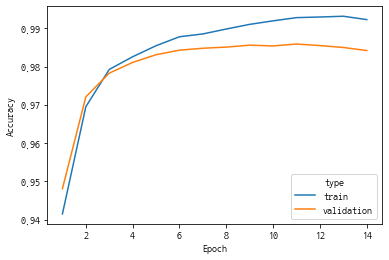

In [6]:
# 정확도 변화 시각화
sns.lineplot(data=df_acc, x='Epoch', y='Accuracy', hue='type')

In [7]:
# test data로 모델 성능 확인

with tf.Session() as sess:
    saver.restore(sess, "./model/cnn_mnist.ckpt")
    test_acc=accuracy.eval(feed_dict={x:x_test, y:y_test})
    print('테스트 정확도 : {:7.5f}'.format(test_acc))

INFO:tensorflow:Restoring parameters from ./model/cnn_mnist.ckpt
테스트 정확도 : 0.98960


INFO:tensorflow:Restoring parameters from ./model/cnn_mnist.ckpt
이 손글씨는 아마도 5 입니다.


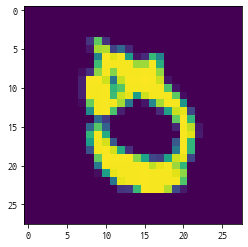

In [35]:
# 이 부분을 반복 실행하여 모델의 정확성을 체감할 수 있습니다.
any_number=np.random.randint(1, 10001)
plt.imshow(x_test[any_number])
with tf.Session() as sess:
    saver.restore(sess, "./model/cnn_mnist.ckpt")
    pred_num= sess.run(tf.argmax(y_pred,1)[0], feed_dict={x: x_test[any_number:any_number+1]})
    print(f"이 손글씨는 아마도 {pred_num} 입니다.")